In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.models import detection
import torchvision
from PIL import Image

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q drive/MyDrive/'Colab Notebooks'/name.zip

In [41]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [6]:
animal_indices_detector = [
    inst_classes.index("bird"),
    inst_classes.index("cat"),
    inst_classes.index("dog"),
    inst_classes.index("horse"),
    inst_classes.index("sheep"),
    inst_classes.index("cow"),
    inst_classes.index("elephant"),
    inst_classes.index("bear"),
    inst_classes.index("zebra"),
    inst_classes.index("giraffe"),
]

In [85]:
class Mock():
    def __init__(self):
        pass
    def __call__(self, x):
        return torch.ones((x.size()[0], 2))

In [86]:
class FindLostAnimal():
    def __init__(self, 
                 model_detection,
                 model_classification_animal,
                 model_classification_dog_breed,
                 model_classification_dog_color,
                 model_classification_dog_tail,
                 indices_animal_detection,
                 indices_cat_dog_classification,
        ):
        self.model_detection = model_detection
        self.model_classification_animal = model_classification_animal
        self.model_classification_dog_breed = model_classification_dog_breed
        self.model_classification_dog_color = model_classification_dog_color
        self.model_classification_dog_tail = model_classification_dog_tail
        self.animals = ["cat", "dog"]
        self.indices_cat_dog_classification = indices_cat_dog_classification
        # a person is huge so detector says the right answers
        self.indices_animal_detection  = indices_animal_detection

    def __get_detection_predictions(self, picture):
        pred = self.model_detection(picture)
        return pred[0]["boxes"], pred[0]["labels"]
    
    def __get_classification_animal_predictions(self, cropped_picture):
        '''
            determine class of an animal
        '''
        pred = self.model_classification_animal(cropped_picture)
        label = pred.argmax(axis=1)[0].item()
        return label
    
    def __get_cropped_image(self, picture, coordinates):
        '''
            picture is a torch.Tensor
            coordinates is a torch.Tensor
        '''
        coordinates = coordinates.detach().numpy().astype(dtype=int)
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]

        return torchvision.transforms.functional.crop(picture, y, x, h, w)

    def __get_dog_features(self, dog_image):
        return [
                self.model_classification_dog_color(dog_image).argmax(axis=1)[0].item(), 
                self.model_classification_dog_tail(dog_image).argmax(axis=1)[0].item(), 
                self.model_classification_dog_breed(dog_image).argmax(axis=1)[0].item(),
        ]

    def __converter_dog_features(self, data):
        raise NotImplementedError()

    def get_features(self, picture_numpy):
        features = []
        # convert picture in tensor
        picture = torch.from_numpy(picture_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256
        picture.unsqueeze_(0)
        
        boxes, labels = self.__get_detection_predictions(picture)
        for box, label in zip(boxes, labels):
            # if it is an animal
            if label in self.indices_animal_detection:
                cropped_image = self.__get_cropped_image(picture, box)
                pred = self.__get_classification_animal_predictions(
                    cropped_image
                )
                # if it is a dog
                if pred in self.indices_cat_dog_classification:
                    features.append(self.__get_dog_features(cropped_image))

        return features


In [87]:
find_lost_animals = FindLostAnimal(model_detection, 
                                   Mock(), 
                                   Mock(), 
                                   Mock(), 
                                   Mock(), 
                                   animal_indices_detector, 
                                   [0])

In [88]:
find_lost_animals.get_features(picture)

[[0, 0, 0]]

In [8]:
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [9]:
image = Image.open('Датасет/Хозяин и собака/125.jpg')

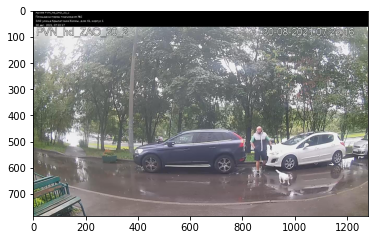

In [10]:
picture = np.asarray(image)
plt.imshow(picture)
plt.show()

In [11]:
picture_torch = torch.from_numpy(picture)
picture_torch = picture_torch.permute(2, 0, 1) / 256

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  """Entry point for launching an IPython kernel.


In [14]:
picture_torch.unsqueeze_(0)
print(picture_torch.shape)

torch.Size([1, 3, 784, 1280])


In [15]:
model_detection.eval()
predicted = model_detection(picture_torch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
predicted[0]

{'boxes': tensor([[ 831.7587,  439.9744,  905.5246,  621.7194],
         [ 382.6417,  449.1526,  817.0447,  623.4727],
         [ 890.1955,  465.1717, 1200.3766,  608.6169],
         [   1.4470,  617.4721,  199.4058,  777.2609],
         [ 929.4611,  611.3790,  997.8511,  673.8352],
         [1205.2411,  477.6760, 1280.0000,  569.9994],
         [ 262.9518,  533.9183,  321.4564,  586.2932],
         [ 899.0854,  493.0200,  916.3837,  531.3463],
         [ 902.9169,  488.3268,  924.8499,  521.8986],
         [ 889.1664,  486.8090,  921.7327,  574.9911],
         [1013.9813,  480.9804, 1062.4558,  524.6622],
         [1023.5477,  490.5036, 1048.2637,  520.7574],
         [1180.3875,  458.1861, 1273.7582,  513.5533],
         [ 263.9092,  541.5005,  329.6707,  589.2462],
         [1041.3051,  480.8751, 1082.7355,  521.6682],
         [1026.1954,  501.1839, 1046.8453,  527.0827],
         [1170.2826,  463.7829, 1276.8120,  589.5341],
         [ 260.1816,  548.8931,  321.2407,  616.8027],
 

In [18]:
boxes = predicted[0]['boxes']
labels = predicted[0]['labels']

In [ ]:
inst_classes.index('person')

1

In [ ]:
a = (labels == 18).nonzero().item()
print (a)

4


In [19]:
boxes = boxes.detach().numpy()

In [31]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()


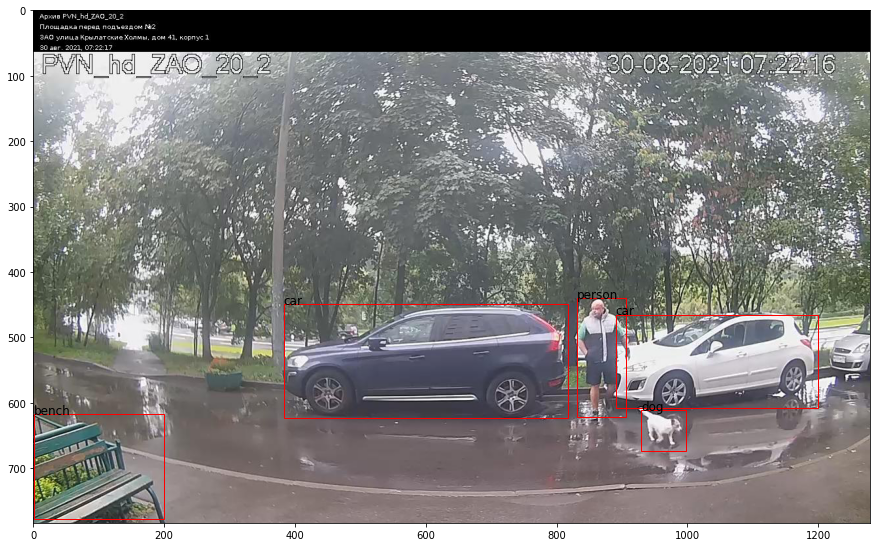

In [32]:
draw_pic_with_rect(picture, boxes, labels, 5)

In [28]:
x1, y1, x2, y2 = boxes[0]

In [33]:
# picture is a torch.Tensor
# coordinates is a torch.Tensor

def get_cropped_image(picture, coordinates):
    coordinates = coordinates.astype(dtype=int)
    x = coordinates[0]
    y = coordinates[1]
    w = coordinates[2] - coordinates[0]
    h = coordinates[3] - coordinates[1]

    return torchvision.transforms.functional.crop(picture, y, x, h, w)

Нижняя по вертикали, левая по горизонтали

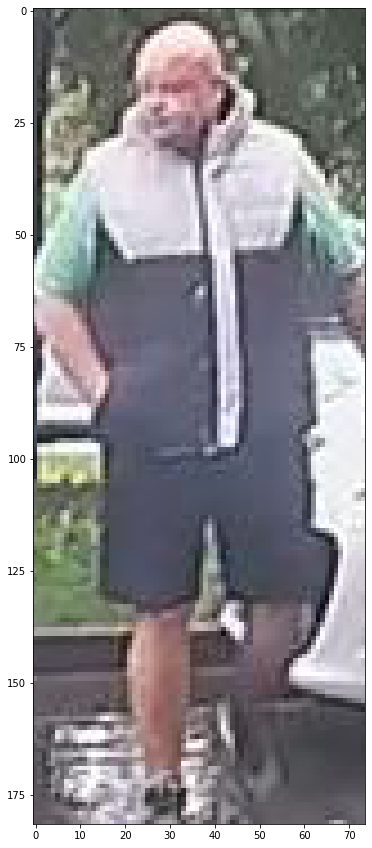

In [34]:
# plt.imshow(fragment_numpy.astype(int))
draw_pic_with_rect(get_cropped_image(picture_torch, boxes[0]), [], [])

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-10-11 18:47:11--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-10-11 18:47:11 (64.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
class ModelClassification(torch.nn.Module):
    def __init__(self, network, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network = network
        self.transforms = torchvision.\
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    def predict_preprocessed(self, x):
        return self.network(x)

    def get_label(self, pred, categories, top=5):
        top_prob, top_catid = torch.topk(pred, top)
        top_prob = top_prob[0]
        top_catid = top_catid[0]
        for i in range(top):
            print(categories[top_catid[i]])

    def predict(self, x):
        x = self.transforms(x)
        return self.predict_preprocessed(x)

In [ ]:
model_classification = ModelClassification(torchvision.models.resnet34(pretrained = True))
model_classification.eval()
picture = get_cropped_image(picture_torch, boxes[0])
preds = model_classification.predict(picture.unsqueeze(0))

In [ ]:
model_classification.get_label(preds, categories)

lab coat 8.098236083984375
crutch 7.842294692993164
croquet ball 6.9661126136779785
jean 6.679392337799072
neck brace 6.643121242523193
